# `litebird_sim` example notebook 

### Attention! This notebook can work only after having downloaded the Litebird IMO informations.
#### Have a look at [the documentation](https://litebird-sim.readthedocs.io/en/master/tutorial.html#interacting-with-the-imo) to install `litebird_imo`, the interface to the IMO

In [1]:
import litebird_sim as lbs
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
import astropy
from astropy.time import Time
import os
import h5py
%matplotlib inline

In [2]:
telescope = 'MFT'
channel = 'M1-140'
mission_time_days = 365
nside = 64
detlist = ['M03_030_QA_140T','M03_030_QA_140B']

In [3]:
start_time = astropy.time.Time('2025-01-01T00:00:00')
base_path = ".test"
#initializing the IMO
imo = lbs.Imo()

#initializing the simulation
sim = lbs.Simulation(base_path=base_path,#mpi_comm=comm,  <--- needed if parallelizing
                       start_time=start_time,duration_s=mission_time_days*24*3600.0)
#loading the instrument metadata
inst_info = sim.imo.query("/releases/v1.0/satellite/"+telescope+"/instrument_info")
#generating the quaternions of the instrument 
sim.generate_spin2ecl_quaternions(imo_url="/releases/v1.0/satellite/scanning_parameters/")
#loading instrument info
inst = lbs.InstrumentInfo(name=telescope, 
    boresight_rotangle_rad=np.deg2rad(inst_info.metadata["boresight_rotangle_deg"]),
    spin_boresight_angle_rad=np.deg2rad(inst_info.metadata["spin_boresight_angle_deg"]),
    spin_rotangle_rad=np.deg2rad(inst_info.metadata["spin_rotangle_deg"]),)

hwp_radpsec = inst_info.metadata["hwp_rpm"]*2*np.pi/60


/home/sgiardie/.local/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1440 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/sgiardie/.local/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1441 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/sgiardie/.local/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1441 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [4]:
#filling dets with info and detquats with quaternions of the detectors in detlist
dets=[]
detquats=[]
for n_det in detlist:
    det=lbs.DetectorInfo.from_imo(url="/releases/v1.0/satellite/"+telescope+"/"+channel+"/"
                                  +n_det+"/detector_info",imo=imo)
    det.sampling_rate_hz = 1   #we set a small sampling rate to produce 1 yr tod without taking too much memory
    dets.append(det)
    detquats.append(det.quat)

#### Making TOD and maps of CMB+foreground

In [5]:
#creating one observation 
(obs_cmb_fg,) = sim.create_observations(detectors= dets,
    n_blocks_det = 1,    
    n_blocks_time = 1,  #blocks different from one if parallelizing
    )

/home/sgiardie/.local/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [6]:
pointings=[]
for obs in sim.observations:
    pointings.append(lbs.get_pointings(obs,
    spin2ecliptic_quats = sim.spin2ecliptic_quats,
    detector_quats = detquats,
    bore2spin_quat = inst.bore2spin_quat,
    hwp = lbs.IdealHWP(hwp_radpsec),   #applies hwp rotation angle to the polarization angle                                  
    store_pointings_in_obs=True,       #if True, stores colatitude and longitude in obs_cmb_fg.pointings,
                                       #and the polarization angle in obs_cmb_fg.psi
))

`pointings` is a list with a $N_{\rm{det}}$ x $N_{\rm{sample}}$ x (colatitude, longitude, pol angle) array. The number of those arrays depends on the number of observations in `sim.observations`

In [16]:
pointings[0].shape

(2, 31536000, 3)

In [8]:
#loading channel info
ch_info = []
ch_info.append(lbs.FreqChannelInfo.from_imo(url="/releases/v1.0/satellite/"
                               +telescope+"/"+channel+"/channel_info",imo=imo))

In [9]:
#let's make an input CMB+foreground map  

#this sets the parameters for the generation of the map
Mbsparams = lbs.MbsParameters(
        make_cmb = True,
        make_fg = True,
        seed_cmb = 1,
        fg_models = ["pysm_synch_0", "pysm_freefree_1","pysm_dust_0"], #set the FG models you want
        gaussian_smooth = True,   #if True, smooths the input map by the beam of the channel
        bandpass_int = False,     #if True, integrates over the top-hat bandpass of the channel
        nside = nside,
        units = "K_CMB",
        maps_in_ecliptic = False,  
    )

mbs = lbs.Mbs(simulation = sim,parameters = Mbsparams,
              channel_list = ch_info   
             # detector_list = dets      #use detector_list instead of channel_list if your sim has detectors 
                                         #from different channels. It would produce a map for each detector in dets
             )
maps = mbs.run_all()[0]         #generates the map as a dictionary

[2022-06-20 11:41:21,569 INFO MPI#0000] generating and saving cmb simulations
[2022-06-20 11:41:21,584 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-06-20 11:41:21,585 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /home/sgiardie/lbs/litebird_sim/notebooks/.test/cmb/0000/cmb_0000_date_220620.fits
  warnings.warn(f"Access data from {full_path}")
[2022-06-20 11:41:21,632 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-06-20 11:41:21,636 INFO MPI#0000] NSIDE = 64
[2022-06-20 11:41:21,639 INFO MPI#0000] ORDERING = RING in fits file
[2022-06-20 11:41:21,641 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-06-20 11:41:21,712 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-06-20 11:41:21,714 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-06-20 11:41:21,717 INFO MPI#000

***************** D
***************** D
***************** D


/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-06-20 11:41:21,924 INFO MPI#0000] NSIDE = 512
[2022-06-20 11:41:21,927 INFO MPI#0000] ORDERING = RING in fits file
[2022-06-20 11:41:21,930 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-06-20 11:41:22,079 INFO MPI#0000] NSIDE = 512
[2022-06-20 11:41:22,086 INFO MPI#0000] ORDERING = RING in fits file
[2022-06-20 11:41:22,093 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-06-20 11:41:24,315 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-06-20 11:41:24,316 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[202

In [11]:
for i_obs, obs in enumerate(sim.observations):
    lbs.scan_map_in_observations(
            obs = obs, 
            maps = maps,
         #   pointings = pointings[i_obs], #not needed if pointing already stored in the obs
            input_map_in_galactic = True
        )

be careful, `lbs.scan_map_in_observations` adds signal to the observation.tod

The TOD has shape $N_{\rm{det}}$ x $N_{\rm{sample}}$

In [38]:
obs_cmb_fg.tod.shape

(2, 31536000)

In [16]:
#let's build the output map, with a binned mapmaker
for i_obs, obs in enumerate(sim.observations):
    m_cmb_fg, m_cmb_fg_cov = lbs.make_bin_map(obs = obs,
                         nside = nside,   #one can set also a different resolution than the input map
                    #     pointings = pointings[i_obs],   #not needed if pointing already stored in the obs
                         do_covariance = True,  #this generates the covariance maps
                         output_map_in_galactic = True
                        )

the noise covariance matrix for each pixel is $\sigma^2 \left(A^T A\right)^{-1}$, where $A$ is the pointing matrix, with dimensions $N_{\rm{samples}} × \left(3 × N_{\rm{pixels}} \right)$ and $\sigma$ is in $\mu$K

$\left(A^T A\right)$ represents how many times the pixel has been visited, so $\sigma^2 \left(A^T A\right)^{-1}$ represents the noise of the pixel weighted by the times it has been observed

In [42]:
#the cov map has shape npix x 3 x 3
m_cmb_fg_cov.shape

(49152, 3, 3)

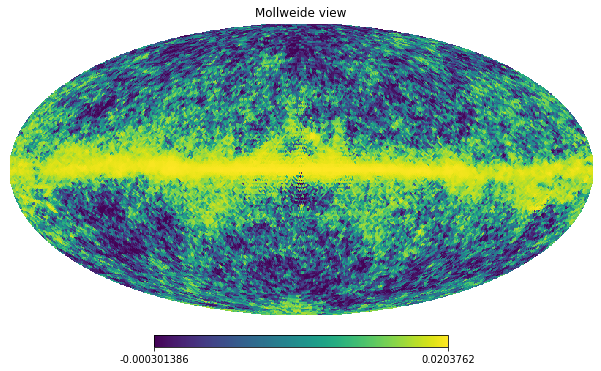

In [17]:
hp.mollview(m_cmb_fg[0], norm = 'hist')

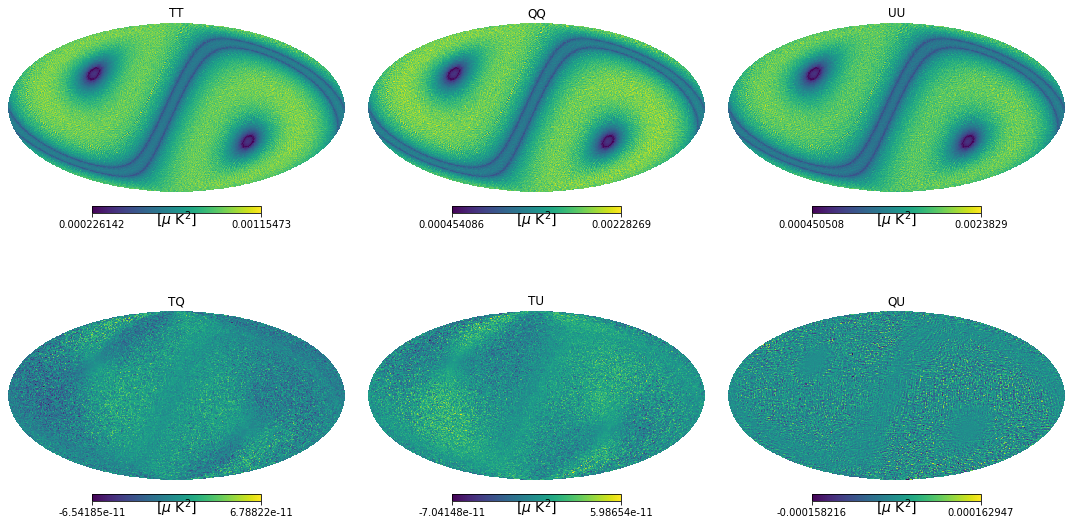

In [13]:
plt.figure(figsize=(15,8))
hp.mollview(m_cmb_fg_cov[:,0,0], sub = 231, title = 'TT', unit = r'[$\mu$ K$^2$]')
hp.mollview(m_cmb_fg_cov[:,1,1], sub = 232, title = 'QQ', unit = r'[$\mu$ K$^2$]')
hp.mollview(m_cmb_fg_cov[:,2,2], sub = 233, title = 'UU', unit = r'[$\mu$ K$^2$]')
hp.mollview(m_cmb_fg_cov[:,0,1], sub = 234, title = 'TQ', unit = r'[$\mu$ K$^2$]')
hp.mollview(m_cmb_fg_cov[:,0,2], sub = 235, title = 'TU', unit = r'[$\mu$ K$^2$]')
hp.mollview(m_cmb_fg_cov[:,1,2], sub = 236, title = 'QU', unit = r'[$\mu$ K$^2$]')

In [44]:
#asserting the input and output maps are close
np.allclose(maps['M1-140'], m_cmb_fg)

True

#### Making TOD and maps of white+1/f noise

we are now adding white + 1/f noise to the CMB+FG TOD

In [12]:
for obs in sim.observations:
    lbs.add_noise_to_observations(obs = obs,
                              noise_type = 'one_over_f',
                              scale = 1, #it can be used to introduce measurement unit conversions when
                                         # appropriate. Default units: [K].
     
                             #random=random      #The parameter `random`, if specified, 
                                                 #must be a random number generator that
                                                 #implements the ``normal`` method
                             )

Let's compare a noise map done with the `litebird_sim` binning mapmaker and with MADAM (binning and destriper)

In [13]:
for i_obs, obs in enumerate(sim.observations):
    m_noise_bin = lbs.make_bin_map(obs = obs,
                         nside = nside,   #one can set also a different resolution than the input map
                        # pointings = pointings[i_obs],   
                         do_covariance = False,  
                         output_map_in_galactic = True
                        )

In [14]:
param_noise_madam = lbs.DestriperParameters(
    nside=nside, return_hit_map=True, return_binned_map=True, return_destriped_map=True, 
    coordinate_system = lbs.coordinates.CoordinateSystem.Galactic,
       iter_max=10, 
)

In [15]:
result = lbs.destripe(sim = sim, params = param_noise_madam, 
                      pointings=pointings
                     )

[2022-06-20 11:42:04,262 WARNING MPI#0000] converting pointings for M03_030_QA_140T from float32 to float64
[2022-06-20 11:42:04,421 WARNING MPI#0000] converting TODs for M03_030_QA_140T from float32 to float64
[2022-06-20 11:42:10,789 WARNING MPI#0000] converting pointings for M03_030_QA_140B from float32 to float64
[2022-06-20 11:42:10,943 WARNING MPI#0000] converting TODs for M03_030_QA_140B from float32 to float64
[2022-06-20 11:44:36,241 INFO MPI#0000] NSIDE = 64
[2022-06-20 11:44:36,242 INFO MPI#0000] ORDERING = NESTED in fits file
[2022-06-20 11:44:36,243 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-06-20 11:44:36,247 INFO MPI#0000] Ordering converted to RING
[2022-06-20 11:44:36,250 INFO MPI#0000] NSIDE = 64
[2022-06-20 11:44:36,251 INFO MPI#0000] ORDERING = NESTED in fits file
[2022-06-20 11:44:36,252 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-06-20 11:44:36,258 INFO MPI#0000] Ordering converted to RING
[2022-06-20 11:44:36,260 INFO MPI#0000] Ordering converted to RING
[2022-06-20 1

In [16]:
m_noise_madam_bin = result.binned_map

In [17]:
m_noise_destr = result.destriped_map

In [18]:
mask = (result.hit_map == 0) | (result.binned_map == 0.0)
m_noise_madam_bin[mask] = np.NaN
m_noise_destr[mask] = np.NaN
m_noise_bin[mask] = np.NaN

let's give a quick look at the difference between the binned map of `make_bin_map` and MADAM. They agree pretty well

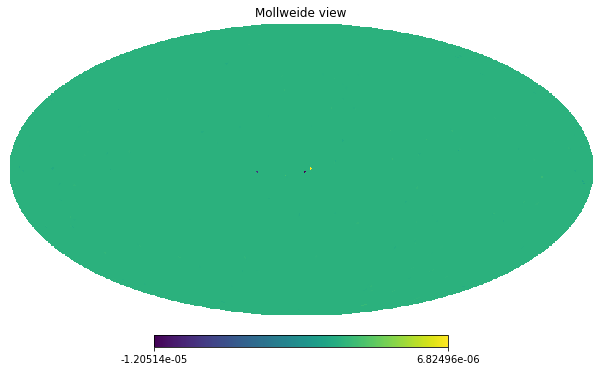

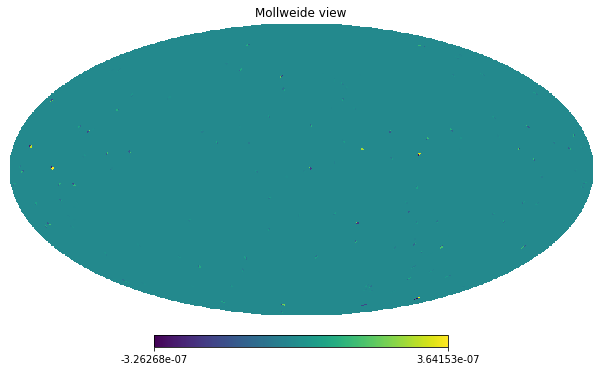

In [19]:
hp.mollview((m_noise_bin - m_noise_madam_bin)[0])
hp.mollview((m_noise_bin - m_noise_madam_bin)[1])

let's also plot the destriped maps

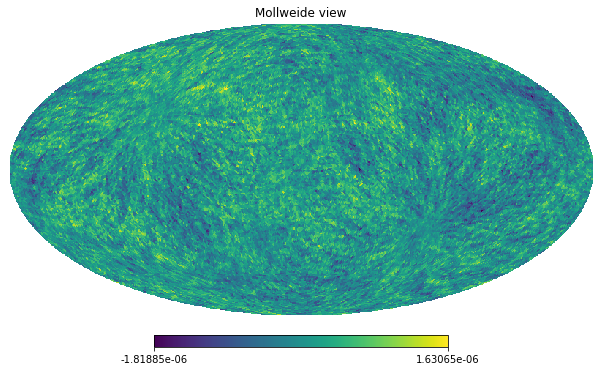

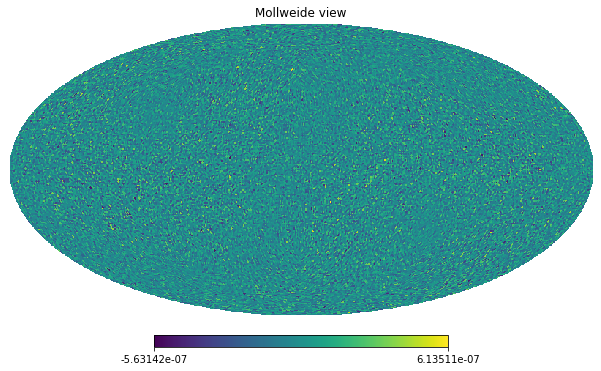

In [20]:
hp.mollview(m_noise_destr[0])
hp.mollview(m_noise_destr[1])

computing the spectra

In [21]:
cl_map_noise_bin = hp.anafast(m_noise_bin)
cl_map_noise_madam_bin = hp.anafast(m_noise_madam_bin)
cl_map_noise_destr = hp.anafast(m_noise_destr)

Text(0.5, 0, '$\\ell$')

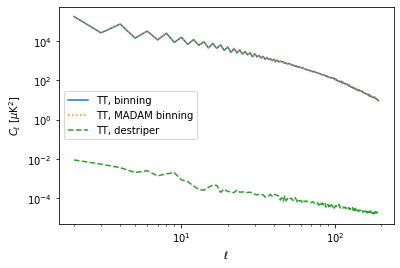

In [22]:
ell = np.arange(cl_map_noise_bin[0].size)
plt.loglog(ell[2:],cl_map_noise_bin[0,2:]*1e12, label = 'TT, binning')
plt.loglog(ell[2:],cl_map_noise_madam_bin[0,2:]*1e12, label = 'TT, MADAM binning', ls = ':')
plt.loglog(ell[2:],cl_map_noise_destr[0,2:]*1e12, label = 'TT, destriper', ls = '--')
plt.legend()
plt.ylabel(r'$C_{\ell}$ [$\mu$K$^2$]')
plt.xlabel(r'$\ell$')

Text(0.5, 0, '$\\ell$')

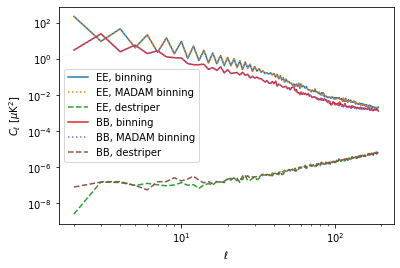

In [23]:
plt.loglog(ell[2:],cl_map_noise_bin[1,2:]*1e12, label = 'EE, binning')
plt.loglog(ell[2:],cl_map_noise_madam_bin[1,2:]*1e12, label = 'EE, MADAM binning', ls = ':')
plt.loglog(ell[2:],cl_map_noise_destr[1,2:]*1e12, label = 'EE, destriper', ls = '--')
plt.loglog(ell[2:],cl_map_noise_bin[2,2:]*1e12, label = 'BB, binning')
plt.loglog(ell[2:],cl_map_noise_madam_bin[2,2:]*1e12, label = 'BB, MADAM binning', ls = ':')
plt.loglog(ell[2:],cl_map_noise_destr[2,2:]*1e12, label = 'BB, destriper', ls = '--')
plt.legend()
plt.ylabel(r'$C_{\ell}$ [$\mu$K$^2$]')
plt.xlabel(r'$\ell$')

#### Making dipole TOD

In [36]:
(obs_dipole,) = sim.create_observations(detectors= dets,
    n_blocks_det = 1,
    n_blocks_time = 1,  #size,
    )

/home/sgiardie/.local/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


If `sim.create_observations` is executed again, `sim.observations` is overwritten. In fact the TOD is null again:

In [37]:
for i_ob in range(len(sim.observations)):
    print(sim.observations[i_ob].tod)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [28]:
for obs in sim.observations:
    orbit = lbs.SpacecraftOrbit(obs.start_time)
    pos_vel = lbs.spacecraft_pos_and_vel(orbit = orbit, obs = obs, delta_time_s=86400.0)

/home/sgiardie/.local/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/sgiardie/.local/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/sgiardie/.local/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 2 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/sgiardie/.local/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 2 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [29]:
for i_obs,obs in enumerate(sim.observations):
    lbs.add_dipole_to_observations(obs = obs, pos_and_vel =  pos_vel, pointings = pointings[i_obs], 
                               dipole_type=lbs.DipoleType.TOTAL_FROM_LIN_T)

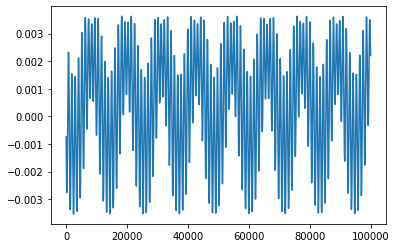

In [30]:
plt.plot(obs_dipole.tod[0,:100000])

In [34]:
for i_obs,obs in enumerate(sim.observations):
    m_dipole = lbs.make_bin_map(obs = obs,
                         nside = nside,   #one can set also a different resolution than the input map
                         pointings = pointings[i_obs],   
                         do_covariance = False,  
                         output_map_in_galactic = True
                        )

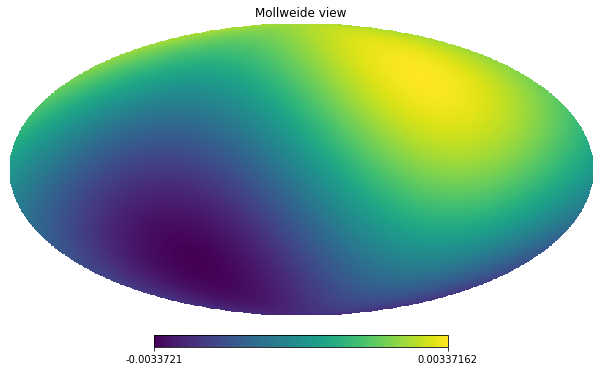

In [35]:
hp.mollview(m_dipole[0])

let's fit the dipole map to see if the dipole orientation agrees with Planck one (see arxiv:1807.06207)

colatitude: 0.7286226027948965,
longitude:  4.6080357444

In [42]:
hp.fit_dipole(m_dipole[0])

(-1.0213998956467993e-07, array([-0.00023297, -0.00222626,  0.00250823]))

In [43]:
hp.vec2ang(np.array([-0.00023297, -0.00222626,  0.00250823]))

(array([0.7286163]), array([4.60812212]))

the agreement is pretty good (we have also orbital dipole)